# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [1]:
np.random.seed(0)

In [2]:
# From the assignment; The function that we are goint to approximate
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
# Generate samples from the FrankeFunction with some optional noise
def franke_sampler(x, y, noise=.1):
    f = FrankeFunction(x, y).reshape(len(x), 1)
    var_eps = noise * np.var(f)
    z = f + np.sqrt(var_eps)*np.random.randn(len(x), 1)
    return (z, f, var_eps)

In [4]:
# Create a mesh with sn uniform randomly scattered points in the rectangle (x_start, y_start), (x_end, y_end). Returned ndarrays have shape (sn, 1)
def randmesh(sn=500, x_start=0., y_start=0., x_end=1., y_end=1.):
    x = np.random.uniform(x_start, x_end, (sn, 1))
    y = np.random.uniform(y_start, y_end, (sn, 1))
    return (x, y)

In [5]:
# Make design matrix with polinomial degree np in two variables
def make_design_matrix(x, y, pn=5):
    X = np.ndarray([len(x), int((pn+1)*(pn+2)/2)])

    ex = [0]*int((pn+1)*(pn+2)/2)
    ey = [0]*int((pn+1)*(pn+2)/2)
    kx = ky = 0
    for i in range(pn+1):
        for j in range(i+1):
            ex[kx] = j
            kx += 1
        for j in range(i,-1,-1):
            ey[ky] = j
            ky += 1

    for i, (xi, yi) in enumerate(zip(x, y)):
        X[i,:] = [(xi**px)*(yi**py) for px, py in zip(ex, ey)]
    
    return X

In [6]:
# Defining some useful functions
def mse(y, y_tilde):
    return np.mean(np.mean((y - y_tilde)**2, axis=1, keepdims=True))

def r2(y, y_tilde):
    return 1 - sum((y - np.mean(y_tilde, axis=1, keepdims=True))**2)/sum((y - np.mean(y))**2)

def bias(f, y_tilde):
    return np.mean((f - np.mean(y_tilde, axis=1, keepdims=True))**2)

def var(y):
    return np.mean(np.var(y, axis=1, keepdims=True))

def scale(X):
    X = np.copy(X)
    if X.shape[1] == 1:
        return X
    X -= np.mean(X, axis=0, keepdims=True)
    X[:,0] = 1
    return X

# NOTE: Choose k such that len(z)%k is zero, ie the split is even!
def split(y, k):
    n = len(y)
    s = n//k  # samples in each split
    last_idx = n - n%k  # remove overshooting samples
    test_splits = [list(range(i, i+s)) for i in range(0, last_idx, s)]
    train_splits = [list(set(range(last_idx)) - set(test_split)) for test_split in test_splits]
    return (train_splits, test_splits)

In [7]:
x, y = randmesh(sn=1000)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=.1)
max_pol_order = 30
bootstraps = 30

## OLS with bootstrap resampling

In [8]:
def ols_bootstrap(*arrays, train_size=.7, bootstraps=30):
    train_test_arrays = skl.model_selection.train_test_split(*arrays, train_size=train_size)
    if len(train_test_arrays) < 4:
        X_train, X_test, z_train, z_test = train_test_arrays[:4]
        f_test = z_test
    else:
        X_train, X_test, z_train, z_test, _, f_test = train_test_arrays
    
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    mse_train = np.ndarray(bootstraps)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        mse_train = mse(z_resampled, X_resampled @ beta_hat)
        z_test_tilde[:, bs] = (X_test @ beta_hat).ravel()
    
    mse_train = np.mean(mse_train)
    mse_test = mse(z_test, z_test_tilde)
    bias_test = bias(z_test, z_test_tilde)
    var_test = var(z_test_tilde)
    
    return (mse_train, mse_test, bias_test, var_test)

### OLS bias-variance tradeoff

In [9]:
ols_bs_df = DataFrame(columns=["pol order", "train mse", "mse", "bias", "var"])

for pn in range(max_pol_order):
    X = make_design_matrix(x, y, pn=pn)
    results = ols_bootstrap(X, z, f, train_size=.7, bootstraps=30)
    ols_bs_df.loc[pn] = [pn, *results]

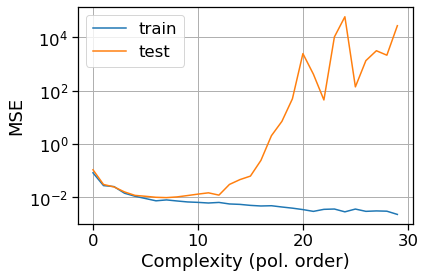

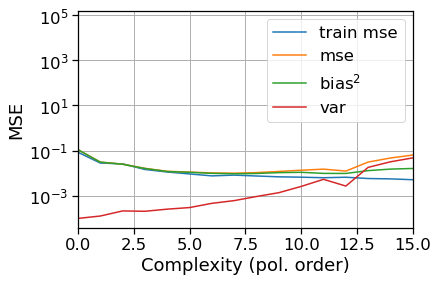

In [10]:
ax = ols_bs_df.plot(x="pol order", y=["train mse", "mse"], logy=True)
ax.legend(["train", "test"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

ax = ols_bs_df.plot(x="pol order", logy=True)
ax.legend(["train mse", "mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")
ax.set_xlim(0,15)
#ax.set_ylim(1E-4,1)
ax.grid(True)
plt.show()

In [25]:
1 - np.min(ols_bs_df["mse"])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.8952650200049647

## OLS with $k$-fold cross-validation resampling
The data is randomized, so we don't need to do that again.

In [11]:
def ols_kfold(X, z, k=50):
    splits = split(z, k)

    mse_train = np.ndarray(k)
    mse_test = np.ndarray(k)

    for i, (train_split, test_split) in enumerate(zip(*splits)):
        X_train = X[train_split]
        z_train = z[train_split]
        X_test = X[test_split]
        z_test = z[test_split]

        X_train = scale(X_train)
        X_test = scale(X_test)        

        beta_hat = np.linalg.pinv(X_train) @ z_train
        mse_train[i] = mse(z_train, X_train @ beta_hat)
        mse_test[i] = mse(z_test, X_test @ beta_hat)

    return (np.mean(mse_train), np.mean(mse_test))

### OLS train vs. test MSE

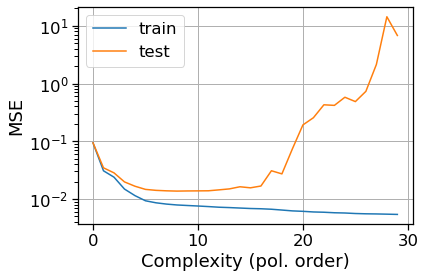

In [12]:
ols_k_df = DataFrame(columns=["pol order", "train", "test"])

for pn in range(30):
    X = make_design_matrix(x, y, pn=pn)
    results = ols_kfold(X, z, k=50)
    ols_k_df.loc[pn] = [pn, *results]

ax = ols_k_df.plot(x="pol order", logy=True)
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

In [13]:
1 - np.min(ols_k_df["test"])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.8539521904349343

## Ridge with bootstrap resampling

In [26]:
def ridge_bootstrap(*arrays, lambdas=[], train_size=.5, bootstraps=30):
    train_test_arrays = skl.model_selection.train_test_split(*arrays, train_size=train_size)
    if len(train_test_arrays) < 4:
        X_train, X_test, z_train, z_test = train_test_arrays[:4]
        f_test = z_test
    else:
        X_train, X_test, z_train, z_test, _, f_test = train_test_arrays
    
    mse_train = np.ndarray(bootstraps)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
   
    n, p = X_train.shape
    X_train = X_train[:p,:p]
    z_train = z_train[:p]
    X_test = X_test[:p,:p]
    z_test = z_test[:p]
    f_test = f_test[:p]
    
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    num_lambdas = len(lambdas)
    mse_train_buf = np.ndarray(bootstraps)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)
    bias_test = np.ndarray(num_lambdas)
    var_test = np.ndarray(num_lambdas)
    
    z_test_tilde = np.ndarray((p, bootstraps))
    
    for i, lmd in enumerate(lambdas):
        L = lmd*np.identity(p)
        
        for bs in range(bootstraps):
            X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)  
            
            U, s, Vt = np.linalg.svd(X_resampled)
            S = np.diag(s)
            beta_hat = Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T @ z_resampled
            
            mse_train_buf[bs] = mse(z_resampled, X_resampled @ beta_hat)       
            z_test_tilde[:,bs] = (X_test @ beta_hat).ravel()

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = mse(z_test, z_test_tilde)
        bias_test[i] = bias(f_test, z_test_tilde)
        var_test[i] = var(z_test_tilde)
    
    return (mse_train, mse_test, bias_test, var_test)

### Ridge bias-variance tradeoff

In [39]:
num_lambdas = 20

lambdas = np.logspace(-5, 2, num_lambdas)
polynomial_orders = list(range(1,max_pol_order+1, 3))

test_cols = [f"mse_{pn} bias_{pn} var_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_bs_df = DataFrame(columns=["lambda", "train"] + test_cols)
ridge_bs_df["lambda"] = lambdas

for pn in polynomial_orders:
    X = make_design_matrix(x, y, pn=pn)
    mse_train, mse_test, bias_test, var_test = ridge_bootstrap(X, z, f, lambdas=lambdas, train_size=.5, bootstraps=30)
    ridge_bs_df[f"train"] = mse_train
    ridge_bs_df[f"mse_{pn}"] = mse_test
    ridge_bs_df[f"bias_{pn}"] = bias_test
    ridge_bs_df[f"var_{pn}"] = var_test


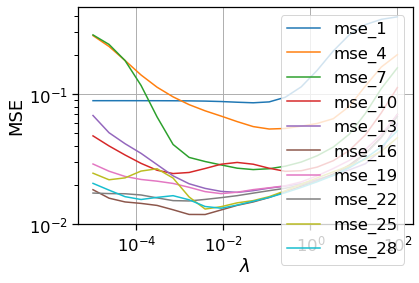

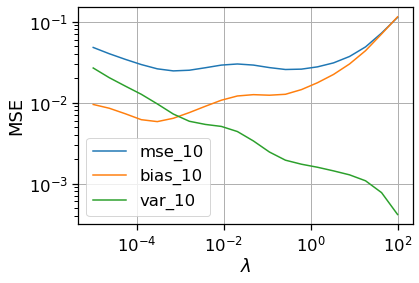

In [43]:
ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

pn = 10
ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}", f"bias_{pn}", f"var_{pn}"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()

In [38]:
1 - np.min(ridge_bs_df["mse_28"])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.8686718458216607

## Ridge with $k$-fold cross-validation resampling

In [29]:
def ridge_kfold(X, z, lambdas=[], k=50):
    splits = split(z, k)
    
    num_lambdas = len(lambdas)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)
    
    mse_train_buf = np.ndarray(k)
    mse_test_buf = np.ndarray(k)
    
    for i, lmd in enumerate(lambdas):
        for j, (train_split, test_split) in enumerate(zip(*splits)):
            X_train = X[train_split]
            z_train = z[train_split]
            X_test = X[test_split]
            z_test = z[test_split]

            n, p = X_train.shape
            X_train = X_train[:p,:p]
            z_train = z_train[:p]
            X_test = X_test[:p,:p]
            z_test = z_test[:p]        
            
            X_train = scale(X_train)
            X_test = scale(X_test)
            
            U, s, Vt = np.linalg.svd(X_train)
            S = np.diag(s)
            L = lmd*np.identity(p)
            beta_hat = Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T @ z_train

            mse_train_buf[j] = mse(z_train, X_train @ beta_hat)
            mse_test_buf[j] = mse(z_test, X_test @ beta_hat)

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = np.mean(mse_test_buf)
    
    return (mse_train, mse_test)

### Ridge train vs. test MSE

In [30]:
num_lambdas = 20

lambdas = np.logspace(-5, 2, num_lambdas)
polynomial_orders = list(range(3, max_pol_order+1, 3))

test_cols = [f"train_{pn} test_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_k_df = DataFrame(columns=["lambda"] + test_cols)
ridge_k_df["lambda"] = lambdas

for pn in polynomial_orders:
    X = make_design_matrix(x, y, pn=pn)
    mse_train, mse_test = ridge_kfold(X, z, lambdas=lambdas, k=50)
    ridge_k_df[f"train_{pn}"] = mse_train
    ridge_k_df[f"test_{pn}"] = mse_test

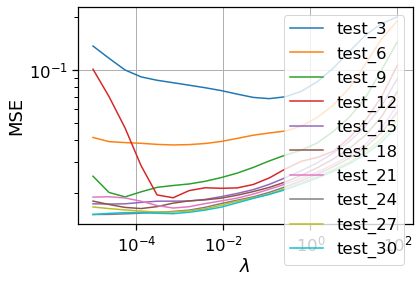

In [31]:
ax = ridge_k_df.plot(x="lambda", y=[f"test_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

In [32]:
1 - np.min(ridge_k_df["test_30"])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.8397541502209985

In [33]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T))

In [34]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.pinv(X_resampled)))

## LASSO